# Binary Classification Model for [PROJECT NAME] Using TensorFlow Decision Forests version 1
### David Lowe
### November 24, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.]

ANALYSIS: [Sample Paragraph: The performance of the preliminary Gradient Boosted Trees model achieved a ROC/AUC benchmark of 0.8814 on the validation dataset. The final model processed the validation dataset with a final ROC/AUC score of 0.8750. When we applied the finalized model to Kaggle's test dataset, the model achieved a ROC/AUC score of 0.8864.]

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Binary Classification with [numerical | categorical] attributes

Dataset Reference: [Sample URL: https://www.kaggle.com/c/tabular-playground-series-mar-2021]

One potential source of performance benchmarks: [Sample URL: https://www.kaggle.com/c/tabular-playground-series-mar-2021/leaderboard]

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Train and Evaluate Models
4. Fine-tune and Improve Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Installing TFDF might be necessary when using the script with Google Colab
# !pip install tensorflow_decision_forests

In [3]:
# For managing screen output when using the script with Google Colab
# !pip install wurlitzer

In [4]:
# # Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [5]:
# # Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [6]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [7]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [8]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

2021-11-24 00:53:14.457995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 00:53:14.458076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# For managing screen output and model plotting when using the script with Google Colab

# try:
#   from wurlitzer import sys_pipes
# except:
#   from colabtools.googlelog import CaptureLog as sys_pipes

# from IPython.core.magic import register_line_magic
# from IPython.display import Javascript

### 1.b) Set up the controlling parameters and functions

In [10]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.AUC()]

# Define the directory locations and file names
TRAIN_DATASET = 'train.csv'
TEST_DATASET = 'test.csv'

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.7.0
Found TensorFlow Decision Forests v0.2.1


2021-11-24 00:53:16.601211: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-24 00:53:16.601294: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 00:53:16.601337: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (20d838f3f8d1): /proc/driver/nvidia/version does not exist


In [11]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [12]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [14]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/train.csv

--2021-11-24 00:53:16--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/train.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.228.65, 13.226.228.127, 13.226.228.118, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.228.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77937692 (74M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>]  74.33M  2.93MB/s    in 34s     

2021-11-24 00:53:50 (2.19 MB/s) - ‘train.csv’ saved [77937692/77937692]



In [15]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont2     cont3  \
0   0    A    I    A    B    B   BI    A    S    Q  ...  0.759439  0.795549   
1   1    A    I    A    A    E   BI    K    W   AD  ...  0.386385  0.541366   
2   2    A    K    A    A    E   BI    A    E   BM  ...  0.343255  0.616352   
3   3    A    K    A    C    E   BI    A    Y   AD  ...  0.831147  0.807807   
4   4    A    I    G    B    E   BI    C    G    Q  ...  0.338818  0.277308   

      cont4     cont5     cont6     cont7     cont8     cont9    cont10 target  
0  0.681917  0.621672  0.592184  0.791921  0.815254  0.965006  0.665915      0  
1  0.388982  0.357778  0.600044  0.408701  0.399353  0.927406  0.493729      0  
2  0.793687  0.552877  0.352113  0.388835  0.412303  0.292696  0.549452      0  
3  0.800032  0.619147  0.221789  0.897617  0.633669  0.760318  0.934242      0  
4  0.610578  0.128291  0.578764  0.279167  0.351103  0.357084  0.328960      1  

[5 rows x 32 columns]


In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cat10   300000 non-null  object 
 12  cat11   300000 non-null  object 
 13  cat12   300000 non-null  object 
 14  cat13   300000 non-null  object 
 15  cat14   300000 non-null  object 
 16  cat15   300000 non-null  object 
 17  cat16   300000 non-null  object 
 18  cat17   300000 non-null  object 
 19  cat18   300000 non-null  object 
 20  cont0   300000 non-null  float64
 21  cont1   30

In [17]:
print(df_dataset_import.describe())

                  id          cont0          cont1          cont2  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean   250183.425697       0.504749       0.494073       0.516632   
std    144320.334812       0.206788       0.213037       0.214851   
min         0.000000      -0.049562       0.084480       0.094493   
25%    125399.750000       0.344985       0.317363       0.326047   
50%    250192.500000       0.479650       0.463170       0.471247   
75%    375246.250000       0.637657       0.693992       0.704625   
max    499999.000000       1.004559       1.009958       1.016600   

               cont3          cont4          cont5          cont6  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.474235       0.504848       0.502257       0.488229   
std         0.216636       0.227474       0.241243       0.211335   
min        -0.045316       0.168071      -0.036379       0.005199   
25%         0.292249       0.2793

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [19]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont2     cont3  \
0    A    I    A    B    B   BI    A    S    Q    A  ...  0.759439  0.795549   
1    A    I    A    A    E   BI    K    W   AD    F  ...  0.386385  0.541366   
2    A    K    A    A    E   BI    A    E   BM    L  ...  0.343255  0.616352   
3    A    K    A    C    E   BI    A    Y   AD    F  ...  0.831147  0.807807   
4    A    I    G    B    E   BI    C    G    Q    A  ...  0.338818  0.277308   

      cont4     cont5     cont6     cont7     cont8     cont9    cont10  \
0  0.681917  0.621672  0.592184  0.791921  0.815254  0.965006  0.665915   
1  0.388982  0.357778  0.600044  0.408701  0.399353  0.927406  0.493729   
2  0.793687  0.552877  0.352113  0.388835  0.412303  0.292696  0.549452   
3  0.800032  0.619147  0.221789  0.897617  0.633669  0.760318  0.934242   
4  0.610578  0.128291  0.578764  0.279167  0.351103  0.357084  0.328960   

   target  
0       0  
1       0  
2       0  
3       0  
4       

In [20]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cat10   300000 non-null  object 
 11  cat11   300000 non-null  object 
 12  cat12   300000 non-null  object 
 13  cat13   300000 non-null  object 
 14  cat14   300000 non-null  object 
 15  cat15   300000 non-null  object 
 16  cat16   300000 non-null  object 
 17  cat17   300000 non-null  object 
 18  cat18   300000 non-null  object 
 19  cont0   300000 non-null  float64
 20  cont1   300000 non-null  float64
 21  cont2   30

In [21]:
print(df_dataset_import.describe())

               cont0          cont1          cont2          cont3  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.504749       0.494073       0.516632       0.474235   
std         0.206788       0.213037       0.214851       0.216636   
min        -0.049562       0.084480       0.094493      -0.045316   
25%         0.344985       0.317363       0.326047       0.292249   
50%         0.479650       0.463170       0.471247       0.387564   
75%         0.637657       0.693992       0.704625       0.644950   
max         1.004559       1.009958       1.016600       0.952187   

               cont4          cont5          cont6          cont7  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.504848       0.502257       0.488229       0.501739   
std         0.227474       0.241243       0.211335       0.203496   
min         0.168071      -0.036379       0.005199       0.090901   
25%         0.279303       0.2764

In [22]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cat10     0
cat11     0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [23]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_import['target']
df_features_train = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 31) df_features_train.shape: (300000, 30) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [24]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [25]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

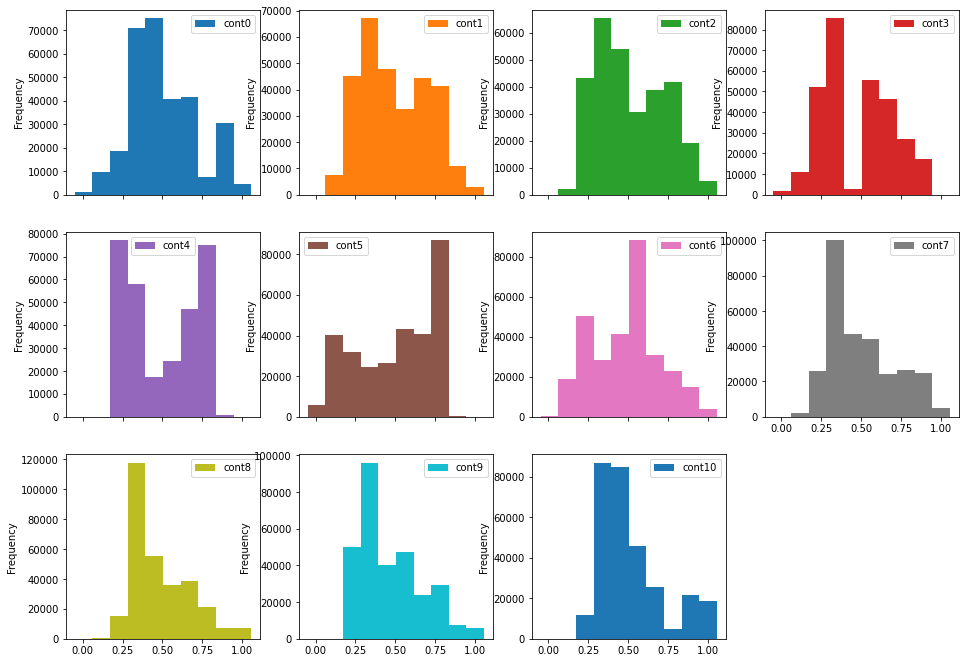

In [27]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

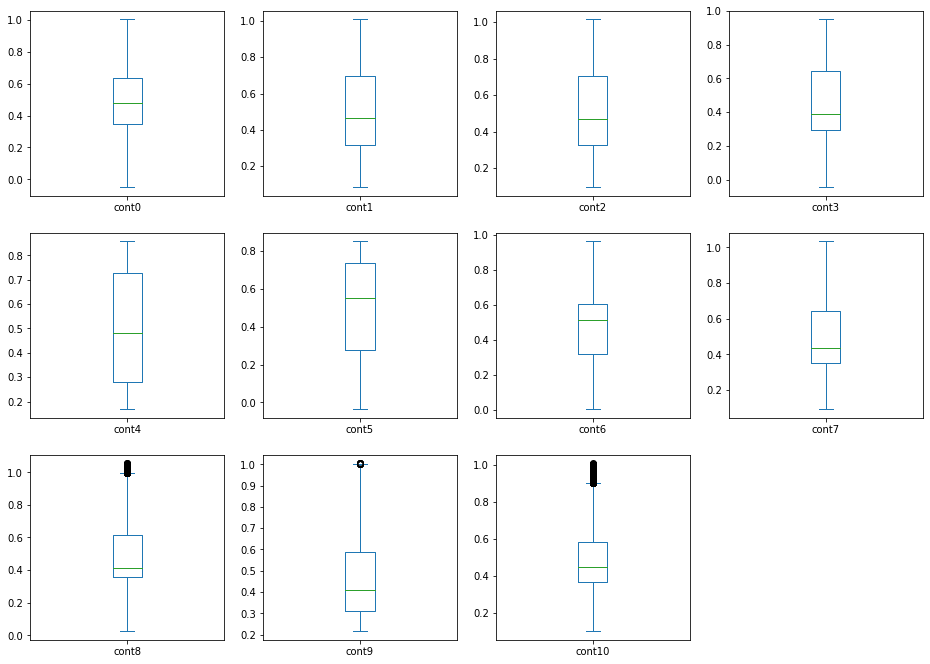

In [28]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

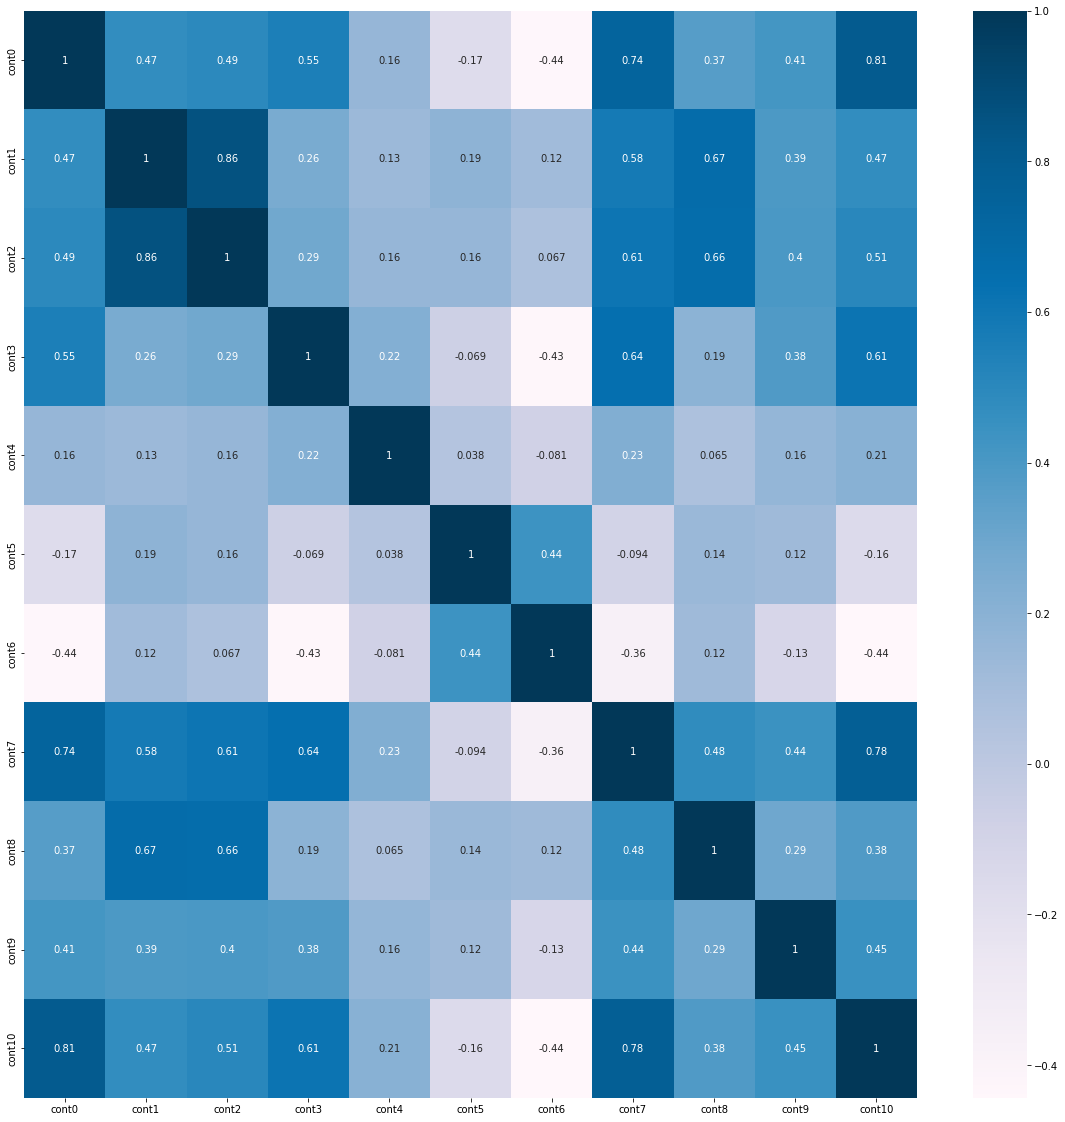

In [29]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [30]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [31]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [32]:
# Split the data further into training and validation datasets
df_dataset_train, df_dataset_valid = train_test_split(df_dataset_import, test_size=VAL_SET_RATIO, random_state=RNG_SEED)
print("df_dataset_train.shape: {} df_dataset_valid.shape: {}".format(df_dataset_train.shape, df_dataset_valid.shape))

df_dataset_train.shape: (240000, 31) df_dataset_valid.shape: (60000, 31)


In [33]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.CLASSIFICATION)
tfds_valid = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_valid, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/home/pythonml/appdev/lib/python3.9/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [34]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3740/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (258 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 178672 (74.4467%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 72531 (30.2213%)
	2: "cat10" CATEGORICAL has-dict vocab-size:259 num-oods:36 (0.015%) most-frequent:"DJ" 25345 (10.5604%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 207227 (86.3446%)
	4: "c

3750/3750 [==============================] - 137s 35ms/step
Model training time: 0:02:19.439674 



In [35]:
RF_eval = RF_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 12s 12ms/step - loss: 0.0000e+00 - accuracy: 0.8464 - auc: 0.8814

loss: 0.0000
accuracy: 0.8464
auc: 0.8814


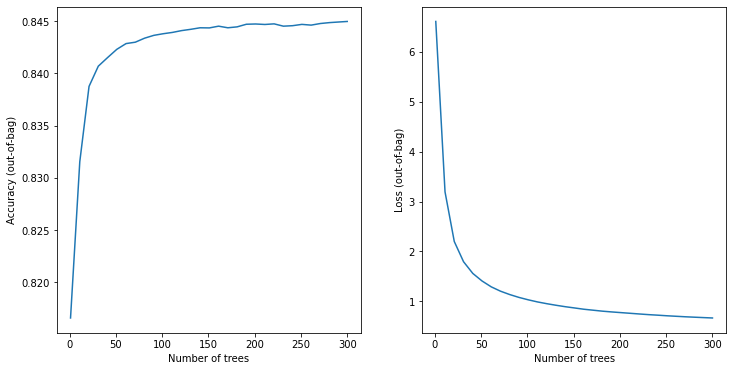

In [36]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Loss (out-of-bag)")
plt.show()

In [37]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(RF_model)

### 3.c) Train and Evaluate the Decision Trees Model

In [38]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3743/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (258 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 178672 (74.4467%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 72531 (30.2213%)
	2: "cat10" CATEGORICAL has-dict vocab-size:259 num-oods:36 (0.015%) most-frequent:"DJ" 25345 (10.5604%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 207227 (86.3446%)
	4: "c

3750/3750 [==============================] - 18s 5ms/step


[INFO cart.cc:375] 9191 nodes before pruning. 1261 nodes after pruning.
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpodp3qlzi
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 1 root(s), 1261 node(s), and 29 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestGeneric" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:00:18.104111 



In [39]:
CART_eval = CART_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 4s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8350 - auc: 0.8616

loss: 0.0000
accuracy: 0.8350
auc: 0.8616


In [40]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(CART_model)

### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [41]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3747/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (258 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 178672 (74.4467%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 72531 (30.2213%)
	2: "cat10" CATEGORICAL has-dict vocab-size:259 num-oods:36 (0.015%) most-frequent:"DJ" 25345 (10.5604%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 207227 (86.3446%)
	4: "c

3750/3750 [==============================] - 114s 30ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.697277
[INFO gradient_boosted_trees.cc:229] Truncates the model to 270 tree(s) i.e. 270  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:270 valid-loss:0.697277 valid-accuracy:0.851248
[INFO kernel.cc:828] Export model in log directory: /tmp/tmphhn43d_n
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


Model training time: 0:02:22.676697 



In [42]:
GBT_eval = GBT_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 5s 4ms/step - loss: 0.0000e+00 - accuracy: 0.8492 - auc: 0.8700

loss: 0.0000
accuracy: 0.8492
auc: 0.8700


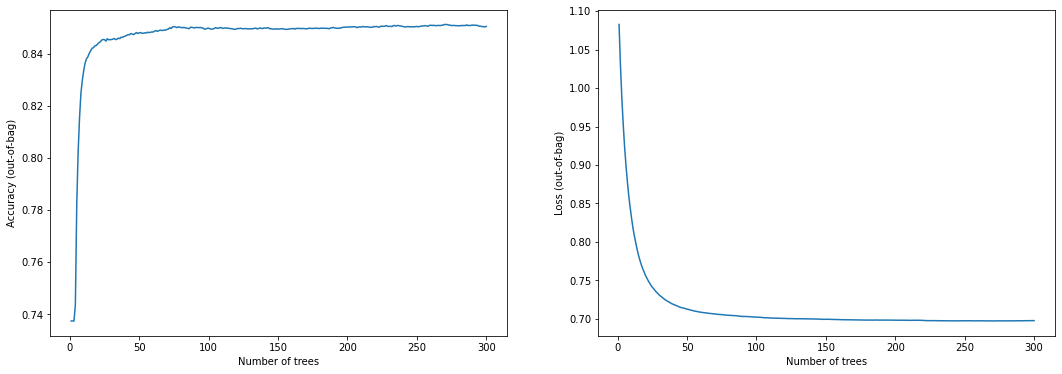

In [43]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Loss (out-of-bag)")
plt.show()

In [44]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(GBT_model)

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [46]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
for num_trees in [300, 500, 750, 1000]:
    # Define the baseline model for benchmarking
    start_time_module = datetime.now()
    reset_random()
    Tuning_model = tfdf.keras.RandomForestModel(num_trees=num_trees, task = tfdf.keras.Task.CLASSIFICATION)

    # Optionally, add evaluation metrics.
    Tuning_model.compile(metrics=DEFAULT_METRICS)

    # Train the model.
    Tuning_model.fit(x=tfds_train)

    Tuning_eval = Tuning_model.evaluate(tfds_valid, return_dict=True)
    print()

    for name, value in Tuning_eval.items():
        print(f"{name}: {value:.4f}")
    print ('Model optimization time:', (datetime.now() - start_time_module), '\n')

3744/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (258 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 178672 (74.4467%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 72531 (30.2213%)
	2: "cat10" CATEGORICAL has-dict vocab-size:259 num-oods:36 (0.015%) most-frequent:"DJ" 25345 (10.5604%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 207227 (86.3446%)
	4: "c

938/938 [==============================] - 12s 12ms/step - loss: 0.0000e+00 - accuracy: 0.8464 - auc: 0.8706

loss: 0.0000
accuracy: 0.8464
auc: 0.8706
Model optimization time: 0:02:34.610190 

3742/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (258 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 178672 (74.4467%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 72531 (30.2213%)
	2: "cat10" CATEGORICAL has-dict vocab-size:259 num-oods:36 (0.015%) most-frequent:"DJ" 25345 (10.5604%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 207227 (86.3446%)
	4: "c

3750/3750 [==============================] - 216s 58ms/step


938/938 [==============================] - 17s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8463 - auc: 0.8719

loss: 0.0000
accuracy: 0.8463
auc: 0.8719
Model optimization time: 0:03:55.327919 

3733/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (258 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 178672 (74.4467%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 72531 (30.2213%)
	2: "cat10" CATEGORICAL has-dict vocab-size:259 num-oods:36 (0.015%) most-frequent:"DJ" 25345 (10.5604%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 207227 (86.3446%)
	4: "c

3750/3750 [==============================] - 316s 84ms/step


938/938 [==============================] - 26s 27ms/step - loss: 0.0000e+00 - accuracy: 0.8464 - auc: 0.8731

loss: 0.0000
accuracy: 0.8464
auc: 0.8731
Model optimization time: 0:05:44.033195 

3746/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (258 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 178672 (74.4467%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 72531 (30.2213%)
	2: "cat10" CATEGORICAL has-dict vocab-size:259 num-oods:36 (0.015%) most-frequent:"DJ" 25345 (10.5604%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 207227 (86.3446%)
	4: "c

938/938 [==============================] - 34s 36ms/step - loss: 0.0000e+00 - accuracy: 0.8465 - auc: 0.8741

loss: 0.0000
accuracy: 0.8465
auc: 0.8741
Model optimization time: 0:07:57.056049 



In [48]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [49]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [50]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.RandomForestModel(num_trees=1000, task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

3738/3750 [============================>.] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 3750
[INFO kernel.cc:393] Number of examples: 240000
[INFO data_spec_inference.cc:290] 36 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cat10 (258 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:759] Dataset:
Number of records: 240000
Number of columns: 31

Number of columns by type:
	CATEGORICAL: 20 (64.5161%)
	NUMERICAL: 11 (35.4839%)

Columns:

CATEGORICAL: 20 (64.5161%)
	0: "cat0" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 178672 (74.4467%)
	1: "cat1" CATEGORICAL has-dict vocab-size:16 zero-ood-items most-frequent:"I" 72531 (30.2213%)
	2: "cat10" CATEGORICAL has-dict vocab-size:259 num-oods:36 (0.015%) most-frequent:"DJ" 25345 (10.5604%)
	3: "cat11" CATEGORICAL has-dict vocab-size:3 zero-ood-items most-frequent:"A" 207227 (86.3446%)
	4: "c

3750/3750 [==============================] - 430s 115ms/step
Model training time: 0:07:12.413194 



In [51]:
Final_model.summary()

Model: "random_forest_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (30):
	cat0
	cat1
	cat10
	cat11
	cat12
	cat13
	cat14
	cat15
	cat16
	cat17
	cat18
	cat2
	cat3
	cat4
	cat5
	cat6
	cat7
	cat8
	cat9
	cont0
	cont1
	cont10
	cont2
	cont3
	cont4
	cont5
	cont6
	cont7
	cont8
	cont9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL" 13.567711 ################
    2.   "cat12" 13.486108 ###############
    3.    "cat3" 13.303312 ###############
    4.   "cat13" 13.111082 ###############
    5.    "cat9" 13.000975 ###############
    6.   "cont0" 12.981266 ###############
    7.  "cont10" 12.958936 ##############
    8.   "cont7" 12.905787 ##############
    9.   "cont9" 12.859664 ########

In [52]:
Final_eval = Final_model.evaluate(tfds_valid, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

938/938 [==============================] - 35s 36ms/step - loss: 0.0000e+00 - accuracy: 0.8465 - auc: 0.8750

loss: 0.0000
accuracy: 0.8465
auc: 0.8750


In [53]:
# Plot the model using Google Colab
# tfdf.model_plotter.plot_model_in_colab(Final_model)

### 5.b) Load Test Dataset and Make Predictions

In [54]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/test.csv

--2021-11-24 01:27:30--  https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021mar/test.csv
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.228.58, 13.226.228.118, 13.226.228.127, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.228.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51558587 (49M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]  49.17M  4.27MB/s    in 11s     

2021-11-24 01:27:46 (4.66 MB/s) - ‘test.csv’ saved [51558587/51558587]



In [55]:
df_features_test = pd.read_csv(TEST_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont1     cont2  \
0   5    A    F    A    A    F   BI    A   AH   AX  ...  0.735690  0.578366   
1   6    A    H    C    A    E   AB    I    F    N  ...  0.313703  0.928885   
2   8    A    N    C    A    F   AB    A   AH   BC  ...  0.448201  0.424876   
3   9    B    L    C    A    F   BI    A    E   AX  ...  0.666092  0.598943   
4  11    A    F    A    B    F   BI    A   AH    I  ...  0.772229  0.479572   

      cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0  0.723154  0.228037  0.356227  0.551249  0.655693  0.598331  0.359987   
1  0.516602  0.600169  0.795224  0.248987  0.654614  0.347944  0.565520   
2  0.344729  0.242073  0.270632  0.746740  0.335590  0.341238  0.252289   
3  0.561971  0.806347  0.735983  0.538724  0.381566  0.481660  0.348514   
4  0.767745  0.252454  0.354810  0.178920  0.763479  0.562491  0.466261   

     cont10  
0  0.947489  
1  0.388580  
2  0.411592  
3  0.325723  
4  0

In [56]:
# # Finalize the test dataset for the prediction activities
# df_target_test = df_features_test['target']
# df_features_test = df_features_test.drop(['target'], axis=1)
# print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

In [57]:
# # Finalize the test dataset for the modeling testing
# array_features_test = preprocessor.transform(df_features_test)
# array_target_test = df_target_test.ravel()
# print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

In [58]:
# test_predictions = test_model.predict(array_features_test)
# print('RMSE for the model is: ', math.sqrt(metrics.mean_squared_error(array_target_test, test_predictions)))
# print('R2 for the model is: ', metrics.r2_score(array_target_test, test_predictions))

In [59]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   5
1   6
2   8
3   9
4  11


In [60]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont1     cont2  \
0    A    F    A    A    F   BI    A   AH   AX    A  ...  0.735690  0.578366   
1    A    H    C    A    E   AB    I    F    N    A  ...  0.313703  0.928885   
2    A    N    C    A    F   AB    A   AH   BC    A  ...  0.448201  0.424876   
3    B    L    C    A    F   BI    A    E   AX    A  ...  0.666092  0.598943   
4    A    F    A    B    F   BI    A   AH    I    A  ...  0.772229  0.479572   

      cont3     cont4     cont5     cont6     cont7     cont8     cont9  \
0  0.723154  0.228037  0.356227  0.551249  0.655693  0.598331  0.359987   
1  0.516602  0.600169  0.795224  0.248987  0.654614  0.347944  0.565520   
2  0.344729  0.242073  0.270632  0.746740  0.335590  0.341238  0.252289   
3  0.561971  0.806347  0.735983  0.538724  0.381566  0.481660  0.348514   
4  0.767745  0.252454  0.354810  0.178920  0.763479  0.562491  0.466261   

     cont10  
0  0.947489  
1  0.388580  
2  0.411592  
3  0.325723 

In [61]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_features_test, task = tfdf.keras.Task.CLASSIFICATION)

In [62]:
# Make batched predictions
test_predictions = Final_model.predict(tfds_test)
print(test_predictions)

[[0.005     ]
 [0.38999853]
 [0.007     ]
 ...
 [0.71699435]
 [0.03      ]
 [0.3759987 ]]


In [63]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   5  0.005000
1   6  0.389999
2   8  0.007000
3   9  0.030000
4  11  0.011000


In [64]:
# # Create the submission file
# submission_file = df_kaggle_submission.to_csv(header=True, index=False)
# filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
# with open(filename, 'w') as f:
#     f.write(submission_file)
#     print('Completed writing output file: ' + filename)

In [65]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [66]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:36:14.121818
